# Cleaning Notebook 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
%matplotlib inline
path = './data/'

def load_data(filepath):
    '''This function loads a dataset, creates a valid date column, and reshuffles the columns.'''
    data = pd.read_csv(filepath).drop('Unnamed: 0', 1)
    #Convert date column into a "real" date column, not a floating number
    data['date'] = data['date'].astype(int).astype(str)
    data['date'] = pd.to_datetime(data['date']).dt.date

    #Reshuffle columns so that date, hour, type are at the front
    observation_cols = list(data.columns.values[:-3])
    cols = list(data.columns.values[-3:])
    cols.extend(observation_cols)
    DF = data[cols]
    return DF

In [2]:
PM = load_data(path+'PM2point5.csv')
PM.head()

,date,hour,type,1001A,1002A,1003A,1004A,1005A,1006A,1007A,...,2706A,2707A,2708A,2709A,2710A,2711A,2835A,2842A,2845A,2846A
0,2014-05-13,0.0,PM2.5,41.0,22.0,54.0,39.0,47.0,56.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-05-13,1.0,PM2.5,40.0,30.0,47.0,NaN,39.0,40.0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-05-13,2.0,PM2.5,39.0,61.0,47.0,NaN,38.0,42.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-05-13,3.0,PM2.5,38.0,24.0,51.0,NaN,40.0,41.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-05-13,4.0,PM2.5,42.0,19.0,NaN,NaN,46.0,41.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### The data is hourly, but some hours are "missing" throughout the entire dataset. 
For example, there are zero records for 16:00 on 2014-05-13 -- that hour is completely blank for all stations. 

To apply time series models effectively, it would be nice to "standardize" the dataset so that all records are equally spaced apart. For example, without 16:00 on May 13, the gap between 15:00 and the preceding record (14:00) will be larger than the gap between 15:00 and the subsequent record (17:00). This is a problem. 

To address this problem, we'll construct a formal "Times" dataframe where ALL hours between May 13, 2014 and December 31, 2016 are represented. We'll merge this "Times" dataframe with the PM2.5 dataframe. Then, we will need to estimate missing PM 2.5 values for the empty hours (newly introduced by the "Times" df.

In [3]:
def merge_times(DF, start_date, end_date):
    '''This function constructs a "Times" dataframe where each row represents one hour. 
    Ultimately, we want to ensure that our DF with PM2.5 data has no missing hours. 
    
    @start_date should be in format datetime.date(2014, 5, 13)
    @end_date should be datetime.date(2017, 1, 1) (if you want all hourly data in 2016)
    '''
    Times = pd.DataFrame(pd.date_range(start_date, end_date, freq='H')[:-1]).rename(columns={0: 'Time'})
    Times['date'] = Times['Time'].dt.date
    Times['hour'] = Times['Time'].dt.hour
    Times['month'] = Times['Time'].dt.month
    Times['weekday'] = Times['Time'].dt.weekday
    Times = Times.drop('Time',1)

    ### Merge PM and Times dataframes together 
    DF_new = DF.merge(Times, on=['date', 'hour'], how='right')
    DF_new = DF_new.sort_values(by=['date','hour']).reset_index(drop=True)
    return DF_new

In [4]:
PM = merge_times(PM, datetime.date(2014, 5, 13), datetime.date(2017, 1, 1))
PM.head()

,date,hour,type,1001A,1002A,1003A,1004A,1005A,1006A,1007A,...,2708A,2709A,2710A,2711A,2835A,2842A,2845A,2846A,month,weekday
0,2014-05-13,0.0,PM2.5,41.0,22.0,54.0,39.0,47.0,56.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
1,2014-05-13,1.0,PM2.5,40.0,30.0,47.0,NaN,39.0,40.0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
2,2014-05-13,2.0,PM2.5,39.0,61.0,47.0,NaN,38.0,42.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
3,2014-05-13,3.0,PM2.5,38.0,24.0,51.0,NaN,40.0,41.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
4,2014-05-13,4.0,PM2.5,42.0,19.0,NaN,NaN,46.0,41.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1


### To make computations simpler, only take stations from 21 other metro areas.
For each metro area, pick station with highest number of observations. See "stations" notebook for more details

In [5]:
metro_codes = pd.read_csv(path+'Station_Metro_Codes.csv')
metro_codes = metro_codes.drop('Unnamed: 0', 1)
stations_to_use = list(metro_codes['StationID'])
metro_codes.head()

,StationID,Metro
0,1589A,Baotou
1,1012A,Beijing
2,1342A,Changsha
3,1434A,Chengdu
4,1419A,Chongqing


## Deal with missing observations: 

**Strategy: For any missing observation, take a weighted average of the most immediate (recorded) prior observation and most immediate (recorded) future observation.** The weights are based on how far away the recorded observations are from the missing observation. For example, let's say we are missing AQI data for 4:00am and 5:00am, but we know that AQI = 30 at 3:00am and AQI = 60 at 6:00am. Instead of simply plugging in the unweighted average AQI value (AQI = 45) for both hours, the code below will produce AQI = 40 for 4:00am and AQI = 50 for 5:00am. For the 4:00am missing value, twice as much weight is placed on the 3:00am recorded value than the 6:00am recorded value, resulting in a weighted average of (2/3 x 30)  + (1/3 x 60) = 40.  

In [6]:
def fill_missing_obs(DF, StationID):
    '''This function fills missing values for a particular station
    @StationID: string format -- equivalent to column name
    @DF: dataframe
    '''
    DF['missing_'+StationID] = np.where(DF[StationID]>-99, 0, 1)
    missing = DF[DF['missing_'+StationID]==1]
    
    first_nonzero = [x for x in np.arange(20) if x not in missing.index][0]
    last_nonzero = [x for x in np.arange(len(DF)-20, len(DF), 1) if x not in missing.index][-1]
    
    for x in missing.index: #For each missing cell
        if x < first_nonzero:
            pass
        elif x > last_nonzero:
            pass

        else:
            non_missing_prior_index = x-1 #Find most recent past record 
            non_missing_post_index = x+1  
    
            while True:
                if non_missing_prior_index in missing.index:
                    non_missing_prior_index = non_missing_prior_index - 1
                else:
                    break
        
            while True:
                if non_missing_post_index in missing.index:
                    non_missing_post_index = non_missing_post_index + 1
                else:
                    break

            prior_datapoint = DF.loc[non_missing_prior_index, StationID] 
            post_datapoint = DF.loc[non_missing_post_index, StationID]

            priordiff = x - non_missing_prior_index
            postdiff = non_missing_post_index - x
            diff = priordiff + postdiff
            prior_weight = postdiff/diff
            post_weight = priordiff/diff
    
            DF.loc[x, StationID] = (prior_weight*prior_datapoint) + (post_weight*post_datapoint) 
    
    #else if x == 0 or x == len(DF)-1
    DF[StationID] = DF[StationID].fillna(method = 'ffill').fillna(method = 'bfill') 
    DF = DF.drop('missing_'+StationID, 1)
    return DF


def remove_and_rename_columns(DF, list_of_stations, list_of_metros):
    '''This function removes station data that will not be used in our model.
    @list_of_stations: a list of stations that we want to keep!
    Function also renames columns so that they are named after metro areas, not station codes
    '''
    cols = ['date', 'month', 'weekday', 'hour']
    stations = [x for x in list_of_stations]
    cols.extend(stations)
    new_DF = DF[cols]
    for m in range(len(list_of_metros)):
        new_DF = new_DF.rename(columns={list_of_stations[m]:list_of_metros[m]})        
    return new_DF

## Interpolate missing observations, and remove stations that aren't in the 20 cities listed above. 

In [7]:
stations_to_use = list(metro_codes['StationID'])
metros_to_use = list(metro_codes['Metro'])

for s in stations_to_use:
    PM = fill_missing_obs(PM, s)

PM_total = remove_and_rename_columns(PM, stations_to_use, metros_to_use)

PM_total.head()

,date,month,weekday,hour,Baotou,Beijing,Changsha,Chengdu,Chongqing,Fuzhou,...,Nanning,Qingdao,Shanghai,Shenyang,Urumqi,Wuhan,Xian,Xining,Yinchuan,Zhengzhou
0,2014-05-13,5,1,0.0,42.0,47.0,52.0,168.0,47.0,32.0,...,49.0,51.0,96.0,56.0,60.0,69.0,27.0,22.0,31.0,43.0
1,2014-05-13,5,1,1.0,49.0,55.0,59.0,180.0,45.0,41.0,...,45.0,48.0,89.0,58.0,64.0,87.0,27.0,26.0,41.0,41.0
2,2014-05-13,5,1,2.0,54.0,48.0,56.0,202.0,45.0,58.0,...,49.0,45.0,80.0,65.0,43.0,83.0,27.0,22.0,45.0,42.0
3,2014-05-13,5,1,3.0,47.0,48.0,49.0,233.0,50.0,29.0,...,53.0,50.0,80.0,67.0,40.0,80.0,27.0,25.0,48.0,40.0
4,2014-05-13,5,1,4.0,46.0,46.0,49.0,274.0,51.0,30.0,...,43.0,59.0,68.0,80.0,37.0,80.0,27.0,22.0,48.0,40.0


## Rescale PM 2.5 values -- take logarithm(PM 2.5) -- such that the distribution of values is Gaussian. 

In [119]:
def rescale_PM25(DF, metros_to_use):
    '''This function rescales each column with PM2.5 by taking the logarithm
    The function then sets the mean to zero
    
    log_mean is the mean of log(PM2.5) in Beijing
    '''
    log_mean = np.log(DF['Beijing']).mean()
    for m in metros_to_use:
        DF[m] = np.log(DF[m])
        DF[m] = DF[m] - DF[m].mean()
    return DF, log_mean


PM_log, log_mean = rescale_PM25(PM_total.copy(), metros_to_use)
print(log_mean)
PM_log.head()

3.897714063665057


,date,month,weekday,hour,Baotou,Beijing,Changsha,Chengdu,Chongqing,Fuzhou,...,Nanning,Qingdao,Shanghai,Shenyang,Urumqi,Wuhan,Xian,Xining,Yinchuan,Zhengzhou
0,2014-05-13,5,1,0.0,0.100745,-0.047566,0.013632,1.287363,0.007071,0.211446,...,0.479931,0.552921,0.934257,0.176176,0.462897,0.317523,-0.384802,-0.683580,-0.355104,-0.397243
1,2014-05-13,5,1,1.0,0.254895,0.109619,0.139926,1.356356,-0.036414,0.459283,...,0.394773,0.492296,0.858545,0.211268,0.527436,0.549325,-0.384802,-0.516526,-0.075519,-0.444871
2,2014-05-13,5,1,2.0,0.352059,-0.026513,0.087740,1.471666,-0.036414,0.806154,...,0.479931,0.427757,0.751936,0.325212,0.129753,0.502257,-0.384802,-0.683580,0.017571,-0.420774
3,2014-05-13,5,1,3.0,0.213223,-0.026513,-0.045791,1.614437,0.068947,0.113006,...,0.558402,0.533118,0.751936,0.355517,0.057432,0.465443,-0.384802,-0.555747,0.082110,-0.469564
4,2014-05-13,5,1,4.0,0.191716,-0.069073,-0.045791,1.776527,0.088749,0.146908,...,0.349311,0.698632,0.589417,0.532851,-0.020529,0.465443,-0.384802,-0.683580,0.082110,-0.469564


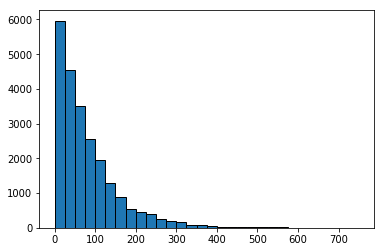

In [9]:
plt.hist(PM_total['Beijing'], edgecolor='black', bins=np.arange(0, 775, 25))
print()

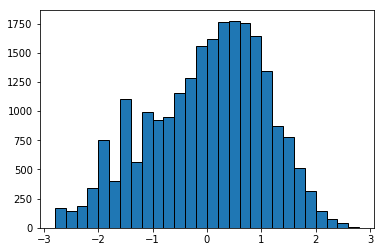

In [11]:
plt.hist(PM_log['Beijing'], edgecolor='black', bins = np.arange(-2.8, 2.9, 0.2))
print()

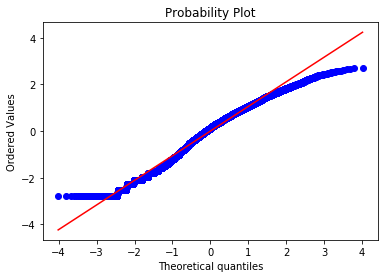

In [12]:
import pylab 
import scipy.stats as stats
stats.probplot(PM_log['Beijing'], dist="norm", plot=pylab)
print()

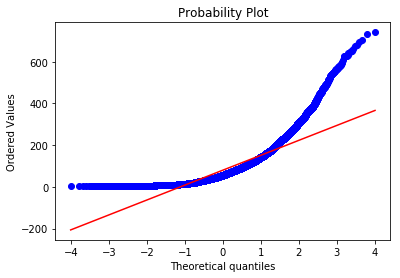

In [13]:
stats.probplot(PM_total['Beijing'], dist="norm", plot=pylab)
print()

-----

# Add Weather Features 

In [14]:
def load_weather_data(city_name):
    '''This function loads weather data for a particular city'''
    
    weather_path = './weather_data/'
    WeatherDF = pd.read_csv(weather_path+city_name+'.csv', usecols=['date', 'hour', 'Humidity',
                                                           'Wind Dir', 'Wind Speed',
                                                            'Temp.', 'Pressure'], encoding='latin1' )
    #Convert date into a datetime variable
    WeatherDF['date'] = pd.to_datetime(WeatherDF['date']).dt.date

    #Convert temperature into a numerical variable
    WeatherDF['Temp.'] = WeatherDF['Temp.'].str.replace('åÊå¡F', '').astype(float)

    #Convert humidity into a numerical variable.
    WeatherDF['Humidity'] = WeatherDF['Humidity'].str.replace('%', '').astype(float)

    #Convert pressure into a numerical variable
    WeatherDF['Pressure'] = WeatherDF['Pressure'].str.replace('åÊin','').astype(float)

    #Convert wind speed into a numerical variable
    WeatherDF['Wind Speed'] = WeatherDF['Wind Speed'].str.replace('åÊmph','')
    WeatherDF['Wind Speed'] = np.where(WeatherDF['Wind Speed'] == 'Calm', 0, WeatherDF['Wind Speed']).astype(float)
    return WeatherDF    

In [15]:
BeijingW = load_weather_data('Beijing')
BeijingW.head()

,date,hour,Humidity,Pressure,Temp.,Wind Dir,Wind Speed
0,2014-01-01,0,15.0,29.92,41.0,West,11.2
1,2014-01-01,1,16.0,29.92,39.2,WSW,6.7
2,2014-01-01,2,15.0,29.92,41.0,WNW,6.7
3,2014-01-01,3,16.0,29.89,41.0,WNW,4.5
4,2014-01-01,4,20.0,29.89,37.4,WNW,6.7


In [16]:
#One tricky variable is wind direction
BeijingW.groupby('Wind Dir').count()[['date']].sort_values(by='date').T

Wind Dir,WSW,SW,West,Calm,ENE,NE,SSW,WNW,NW,ESE,East,SE,NNE,SSE,NNW,South,North,Variable
date,140,340,361,558,843,862,908,925,1187,1210,1439,1469,1628,1674,1705,1940,3642,5460


In [17]:
#Convert wind direction into a numerical variable
#NOTE: indexed at 0 = WEST -- historically wind rarely comes from the West in Beijing (see chart above)
wind_direction = {'North': 90, 'NNE':112.5, 'NE': 135, 'ENE': 157.5, 
                  'East': 180, 'ESE':202.5, 'SE': 225, 'SSE': 247.5,
                  'South': 270,'SSW': 292.5, 'SW': 315, 'WSW': 337.5,
                  'West': 0, 'WNW': 22.5, 'NW': 45, 'NNW': 67.5,
                 'Variable': None, 'Calm': None}

BeijingW['wind_angle'] = BeijingW['Wind Dir'].map(lambda x: wind_direction[x])
BeijingW = BeijingW.drop(['Wind Dir'], 1)

#Merge times
BeijingWeather = merge_times(BeijingW, datetime.date(2014, 5, 13), datetime.date(2017, 1, 1))
BeijingWeather.tail()

,date,hour,Humidity,Pressure,Temp.,Wind Speed,wind_angle,month,weekday
23131,2016-12-31,19,80.0,30.30,24.8,2.2,157.5,12,5
23132,2016-12-31,20,80.0,30.30,23.0,2.2,NaN,12,5
23133,2016-12-31,21,86.0,30.33,26.6,2.2,NaN,12,5
23134,2016-12-31,22,93.0,30.30,23.0,2.2,NaN,12,5
23135,2016-12-31,23,93.0,30.30,21.2,2.2,NaN,12,5


### Fill in blanks for weather data

In [18]:
#same method to fill missing observations
for c in ['Humidity', 'Pressure', 'Temp.', 'Wind Speed']:
    BeijingWeather = fill_missing_obs(BeijingWeather, c)

#For wind_angle, just use the most recent prior observation.
#For most nulls for wind_angle, wind speed is very low (0-2mph), so not too concerned.
#Didn't use fill_missing_obs function because of the circular nature of the wind_angle variable.
#(Jump from 315 to 45 degrees is tricky)

BeijingWeather['wind_angle'] = BeijingWeather['wind_angle'].fillna(method='ffill')
BeijingWeather.tail()

,date,hour,Humidity,Pressure,Temp.,Wind Speed,wind_angle,month,weekday
23131,2016-12-31,19,80.0,30.30,24.8,2.2,157.5,12,5
23132,2016-12-31,20,80.0,30.30,23.0,2.2,157.5,12,5
23133,2016-12-31,21,86.0,30.33,26.6,2.2,157.5,12,5
23134,2016-12-31,22,93.0,30.30,23.0,2.2,157.5,12,5
23135,2016-12-31,23,93.0,30.30,21.2,2.2,157.5,12,5


------

### Merge weather data to create final (hourly) dataset 

In [19]:
#PM_Hour = PM_less.merge(BeijingWeather, on=['date','hour', 'month', 'weekday'])
#PM_Log_Hour = PM_log.merge(BeijingWeather, on=['date','hour', 'month', 'weekday'])

PM_Hour = PM_total.merge(BeijingWeather, on=['date','hour', 'month', 'weekday'])
PM_Log_Hour = PM_log.merge(BeijingWeather, on=['date','hour', 'month', 'weekday'])

#PM_Hour.to_csv('PM25_Hour.csv')
#PM_Log_Hour.to_csv('PM25_Log_Hour.csv')

### Create final (daily) dataset as well 

In [20]:
PM_Day = PM_Hour.groupby('date', as_index=False).mean() #Take daily average of each variable.
#PM_Day.to_csv('PM25_Day.csv')

PM_Log_Day = PM_Log_Hour.groupby('date', as_index=False).mean() #Take daily average of each variable.
#PM_Log_Day.to_csv('PM25_Log_Day.csv')

----------

# Build Random Forests Model

Will require hard-coding variables.

# Autoregressive Features

For this task, we want to predict pollution levels far into the future (at least one day away). Therefore, in terms of autoregressive features, we will only use values that occur at least 24 hours in the past. 

In [21]:
PM_Log_Day.head(2)

,date,month,weekday,Baotou,Beijing,Changsha,Chengdu,Chongqing,Fuzhou,Guangzhou,...,Wuhan,Xian,Xining,Yinchuan,Zhengzhou,Humidity,Pressure,Temp.,Wind Speed,wind_angle
0,2014-05-13,5,1,-0.484826,0.212946,0.131937,0.552211,0.529371,0.317945,0.007916,...,0.285183,-0.397628,-0.352808,-0.049827,-0.057608,42.083333,29.53125,72.900,9.320833,105.000
1,2014-05-14,5,2,-0.915418,-0.635983,0.436676,0.526575,0.091259,-0.074078,-0.478523,...,-0.034798,-0.448887,-0.244927,-1.020090,-0.205736,25.000000,29.68375,67.175,14.820833,110.625


In [22]:
def add_autoregressive_features(DF, Metro, time_steps):
    '''@time_steps: a list of integers indicating which autoregressive values to use
    e.g. [24, 36] means to use the observations from 24 hours ago and 36 hours ago
    '''
    for t in time_steps:
        lagged_values = np.empty(t)
        lagged_values[:] = np.nan
        lagged_values = list(lagged_values)
        lagged_values.extend(list(DF[Metro][:-t]))
        DF[Metro+' t-'+str(t)] = lagged_values
    return DF


time_steps = [24, 36, 48]
day_steps = [1, 2]
BeijHour = add_autoregressive_features(PM_Hour.copy(), 'Beijing', time_steps)
BeijDay = add_autoregressive_features(PM_Day.copy(), 'Beijing', day_steps)
BeijDay = add_autoregressive_features(add_autoregressive_features(BeijDay, 'Wind Speed', 
                                    [1]), 'wind_angle', [1])

BeijLogHour = add_autoregressive_features(PM_Log_Hour.copy(), 'Beijing', time_steps)
BeijLogDay = add_autoregressive_features(PM_Log_Day.copy(), 'Beijing', day_steps)
#BeijLogDay = add_autoregressive_features(add_autoregressive_features(BeijLogDay, 
#                                'Wind Speed', [1]), 'wind_angle', [1])

BeijLogDay.tail(2)

,date,month,weekday,Baotou,Beijing,Changsha,Chengdu,Chongqing,Fuzhou,Guangzhou,...,Xining,Yinchuan,Zhengzhou,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-1,Beijing t-2
962,2016-12-30,12,4,1.02100,1.046435,0.621692,0.965908,0.142983,0.538101,0.413249,...,0.011861,0.840952,1.114661,68.583333,30.40125,21.80,3.154167,151.875,-0.458000,-0.434927
963,2016-12-31,12,5,1.21403,1.713202,0.517860,1.244541,0.715934,0.648190,0.890082,...,-0.480270,1.306136,1.190550,72.500000,30.33000,24.95,2.691667,138.750,1.046435,-0.458000


# Pollution values from other stations 

In [23]:
def add_other_stations(DF, Relevant_Metros, time_steps):
    '''
    The argument 'Relevant Metros' is a list of metros that are close to the target city.
    The argument 'time_steps' is the same as in the "add_autoregressive_features" function.
    '''
    for m in Relevant_Metros:
        for t in time_steps:
            lagged_values = np.empty(t)
            lagged_values[:] = np.nan
            lagged_values = list(lagged_values)
            lagged_values.extend(list(DF[m][:-t]))
            DF[m+' t-'+str(t)] = lagged_values
    return DF   

def final_cleaning(DF, Metro):
    for m in metros_to_use:
        if m != Metro:
            DF = DF.drop(m, 1)
    return DF


BeijingHour = add_other_stations(BeijHour, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [24])
BeijingDay = add_other_stations(BeijDay, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [1])

BeijingLogHour = add_other_stations(BeijLogHour, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [24])
BeijingLogDay = add_other_stations(BeijLogDay, ['Baotou', 'Harbin', 'Qingdao', 'Xian'], [1])

FINAL_Hour = final_cleaning(BeijingHour, 'Beijing')
FINAL_Day = final_cleaning(BeijingDay, 'Beijing')

FINAL_Hour_Log = final_cleaning(BeijingLogHour, 'Beijing')
FINAL_Day_Log = final_cleaning(BeijingLogDay, 'Beijing')

FINAL_Hour.tail(2)

,date,month,weekday,hour,Beijing,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-24,Beijing t-36,Beijing t-48,Baotou t-24,Harbin t-24,Qingdao t-24,Xian t-24
23134,2016-12-31,12,5,22,521.0,93.0,30.3,23.0,2.2,157.5,368.0,109.0,120.0,96.0,162.0,49.0,290.0
23135,2016-12-31,12,5,23,513.0,93.0,30.3,21.2,2.2,157.5,278.0,116.5,109.5,103.0,254.0,58.0,330.0


---------

# Modeling - Log(Day)

## NOTE: we have two Random Forests models: 1) all samples weighted equally and 2) high-pollution samples weighted more heavily.


In [102]:
#Reconvert numbers to original values
#Don't stay in log space

def calculate_R2(preds, test):
    test_mean = np.mean(test)
    SStotal = sum((np.array(test) - test_mean)**2)
    SSE = sum((np.array(test) - np.array(preds))**2)
    return 1 - SSE/SStotal

def custom_ReLU(array):
    '''This function applies a ReLU transformation on an array of data, but instead
    of returning max(0, x), it returns 0.01 for negative values and 
    (0.01 + x)^2 for positive values. The squared term is designed to ensure that 
    observations with high pollution have higher weights.
    '''
    for j in range(len(array)):
        if array[j] < 0:
            array[j] = 0.01
        else:
            array[j] = 0.01+(array[j])**3
    return array   

In [103]:
X = FINAL_Day_Log.drop(['Beijing','date'], 1)
y = FINAL_Day_Log['Beijing']

TrainX = X[2:842]
TrainY = y[2:842]
TestX = X[842:]
TestY = y[842:]

Weights = custom_ReLU(np.array(TrainY))
pd.Series(Weights).describe()

count    840.000000
mean       0.457748
std        1.212476
min        0.010000
25%        0.010000
50%        0.010239
75%        0.257202
max       12.616163
dtype: float64

In [75]:
Weights.sort()

In [104]:
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics

RF = RandomForestRegressor(n_estimators=20, min_samples_leaf=5, random_state=25)
RF2 = RandomForestRegressor(n_estimators=20, min_samples_leaf=5, random_state=25)

#RF is non-weighted, RF2 is weighted version
RF.fit(TrainX, TrainY)
RF2.fit(TrainX, TrainY, sample_weight=Weights)

#Predictions for Training and Test Sets, and for "Regular" and "Weighted" versions.
PredsTrain = RF.predict(TrainX)
Preds = RF.predict(TestX)
PredsTrain2 = RF2.predict(TrainX)
Preds2 = RF2.predict(TestX)

train_score = RF.score(TrainX, TrainY)
score = RF.score(TestX, TestY)
train_score2 = RF2.score(TrainX, TrainY)
score2 = RF2.score(TestX, TestY)

adjusted_Preds = np.exp(3.89 + Preds)
adjusted_Actuals = np.exp(3.89 + TestY)
adjusted_PredsTrain = np.exp(3.89 + PredsTrain)
adjusted_ActualsTrain = np.exp(3.89 + TrainY)

adjusted_Preds2 = np.exp(3.89 + Preds2)
adjusted_Actuals2 = np.exp(3.89 + TestY)
adjusted_PredsTrain2 = np.exp(3.89 + PredsTrain2)
adjusted_ActualsTrain2 = np.exp(3.89 + TrainY)


print('R^2 values for log-space: Unweighted Version')
print('Train Set: ', train_score)
print('Test Set: ', score,'\n')

print('R^2 values for original space: Unweighted Version')
print('Train Set: ', calculate_R2(adjusted_PredsTrain, adjusted_ActualsTrain))
print('Test Set: ', calculate_R2(adjusted_Preds, adjusted_Actuals), '\n')


print('R^2 values for log-space: Weighted Version')
print('Train Set: ', train_score2)
print('Test Set: ', score2,'\n')

print('R^2 values for original space: Weighted Version')
print('Train Set: ', calculate_R2(adjusted_PredsTrain2, adjusted_ActualsTrain2))
print('Test Set: ', calculate_R2(adjusted_Preds2, adjusted_Actuals2))

R^2 values for log-space: Unweighted Version
Train Set:  0.8948057621098354
Test Set:  0.7829638509366188 

R^2 values for original space: Unweighted Version
Train Set:  0.8577179211137795
Test Set:  0.6914624447002269 

R^2 values for log-space: Weighted Version
Train Set:  0.8032636453502712
Test Set:  0.633088709829805 

R^2 values for original space: Weighted Version
Train Set:  0.8335825680667324
Test Set:  0.6412297902025876


--------

# Metrics for Success (aside from R^2)

### Acceptable 24-hour threshold for PM 2.5 is 75.
https://www.transportpolicy.net/standard/china-air-quality-standards/

### "Heavily Polluted" designation if PM 2.5 is 150
https://www.healthandsafetyinshanghai.com/china-air-quality.html

# For rescaled data, the acceptable threshold is 0.41977

In [105]:
#Mean is 3.9
t = np.log(75)-3.89 #0.41977
t2 = np.log(150)-3.89 #1.1129

Results = pd.DataFrame(np.vstack((Preds, TestY))).T
Results2 = pd.DataFrame(np.vstack((Preds2, TestY))).T
ResultsTrain = pd.DataFrame(np.vstack((PredsTrain, TrainY))).T
ResultsTrain2 = pd.DataFrame(np.vstack((PredsTrain2, TrainY))).T

Results = Results.rename(columns={0: 'Predictions', 1: 'Actual'})
Results2 = Results2.rename(columns={0: 'Predictions', 1: 'Actual'})
ResultsTrain = ResultsTrain.rename(columns={0: 'Predictions', 1: 'Actual'})
ResultsTrain2 = ResultsTrain2.rename(columns={0: 'Predictions', 1: 'Actual'})


#Severe Threshold
TP = len(Results[(Results['Predictions']>t2)&(Results['Actual']>t2)])
FP = len(Results[(Results['Predictions']>t2)&(Results['Actual']<t2)])
TN = len(Results[(Results['Predictions']<t2)&(Results['Actual']<t2)])
FN = len(Results[(Results['Predictions']<t2)&(Results['Actual']>t2)])

TP2 = len(Results2[(Results2['Predictions']>t2)&(Results2['Actual']>t2)])
FP2 = len(Results2[(Results2['Predictions']>t2)&(Results2['Actual']<t2)])
TN2 = len(Results2[(Results2['Predictions']<t2)&(Results2['Actual']<t2)])
FN2 = len(Results2[(Results2['Predictions']<t2)&(Results2['Actual']>t2)])

TPT = len(ResultsTrain[(ResultsTrain['Predictions']>t2)&(ResultsTrain['Actual']>t2)])
FPT = len(ResultsTrain[(ResultsTrain['Predictions']>t2)&(ResultsTrain['Actual']<t2)])
TNT = len(ResultsTrain[(ResultsTrain['Predictions']<t2)&(ResultsTrain['Actual']<t2)])
FNT = len(ResultsTrain[(ResultsTrain['Predictions']<t2)&(ResultsTrain['Actual']>t2)])

TPT2 = len(ResultsTrain2[(ResultsTrain2['Predictions']>t2)&(ResultsTrain2['Actual']>t2)])
FPT2 = len(ResultsTrain2[(ResultsTrain2['Predictions']>t2)&(ResultsTrain2['Actual']<t2)])
TNT2 = len(ResultsTrain2[(ResultsTrain2['Predictions']<t2)&(ResultsTrain2['Actual']<t2)])
FNT2 = len(ResultsTrain2[(ResultsTrain2['Predictions']<t2)&(ResultsTrain2['Actual']>t2)])

Recall = TP/(TP+FN)
Precision = TP/(TP+FP)

Recall2 = TP2/(TP2+FN2)
Precision2 = TP2/(TP2+FP2)

RecallT = TPT/(TPT+FNT)
PrecisionT = TPT/(TPT+FPT)

RecallT2 = TPT2/(TPT2+FNT2)
PrecisionT2 = TPT2/(TPT2+FPT2)

print('Test Set Performance:\n')
print('Unweighted Model:')
print('Recall: {0}'.format(round(Recall, 2)))
print('Precision: {0}'.format(round(Precision, 2)), '\n')
print('Weighted Model:')
print('Recall: {0}'.format(round(Recall2, 2)))
print('Precision: {0}'.format(round(Precision2, 2)), '\n')

print('Training Set Performance:\n')
print('Unweighted Model:')
print('Recall: {0}'.format(round(RecallT, 2)))
print('Precision: {0}'.format(round(PrecisionT, 2)), '\n')
print('Weighted Model:')
print('Recall: {0}'.format(round(RecallT2, 2)))
print('Precision: {0}'.format(round(PrecisionT2, 2)), '\n')

Test Set Performance:

Unweighted Model:
Recall: 0.6
Precision: 0.8 

Weighted Model:
Recall: 0.75
Precision: 0.68 

Training Set Performance:

Unweighted Model:
Recall: 0.59
Precision: 0.9 

Weighted Model:
Recall: 0.73
Precision: 0.79 



# Confusion Matrices

### Test Set 

In [106]:
print(pd.DataFrame(np.array(([TP, FP],[FN, TN])), columns=['Bad', 'Good'],
            index=['Predict Bad', 'Predict Good']))
print()
print(pd.DataFrame(np.array(([TP2, FP2],[FN2, TN2])), columns=['Bad', 'Good'],
            index=['Predict Bad', 'Predict Good']))

              Bad  Good
Predict Bad    12     3
Predict Good    8    99

              Bad  Good
Predict Bad    15     7
Predict Good    5    95


### Training Set 

In [107]:
print(pd.DataFrame(np.array(([TPT, FPT],[FNT, TNT])), columns=['Bad', 'Good'],
            index=['Predict Bad', 'Predict Good']))
print()
print(pd.DataFrame(np.array(([TPT2, FPT2],[FNT2, TNT2])), columns=['Bad', 'Good'],
            index=['Predict Bad', 'Predict Good']))

              Bad  Good
Predict Bad    44     5
Predict Good   31   760

              Bad  Good
Predict Bad    55    15
Predict Good   20   750


----
# Plots for Log Space 

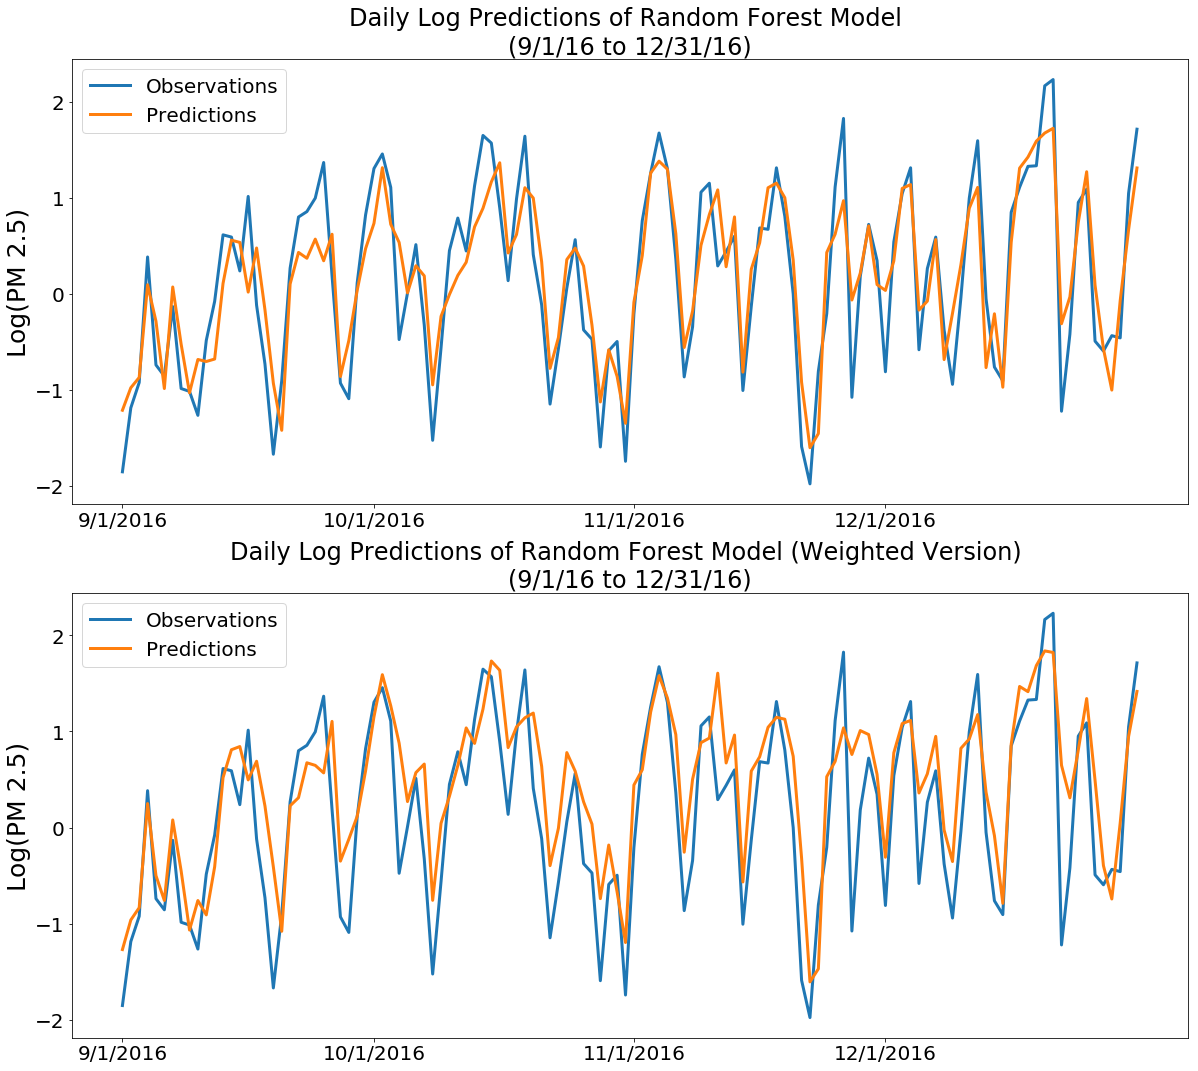

In [108]:
labels = ['9/1/2016', '10/1/2016', '11/1/2016', '12/1/2016']
pos = [842, 872, 903, 933]

plt.figure(figsize=(20, 18))

plt.subplot(211)
plt.plot(TestY, label= 'Observations', linewidth = 3)
plt.plot(np.arange(842, 964), Preds, label='Predictions', linewidth=3)
plt.title('Daily Log Predictions of Random Forest Model \n(9/1/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('Log(PM 2.5)', size=25)
plt.legend(prop={'size':20})

plt.subplot(212)
plt.plot(TestY, label= 'Observations', linewidth = 3)
plt.plot(np.arange(842, 964), Preds2, label='Predictions', linewidth=3)
plt.title('Daily Log Predictions of Random Forest Model (Weighted Version) \n(9/1/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('Log(PM 2.5)', size=25)
plt.legend(prop={'size':20})
print()

# Plots for Original Space 

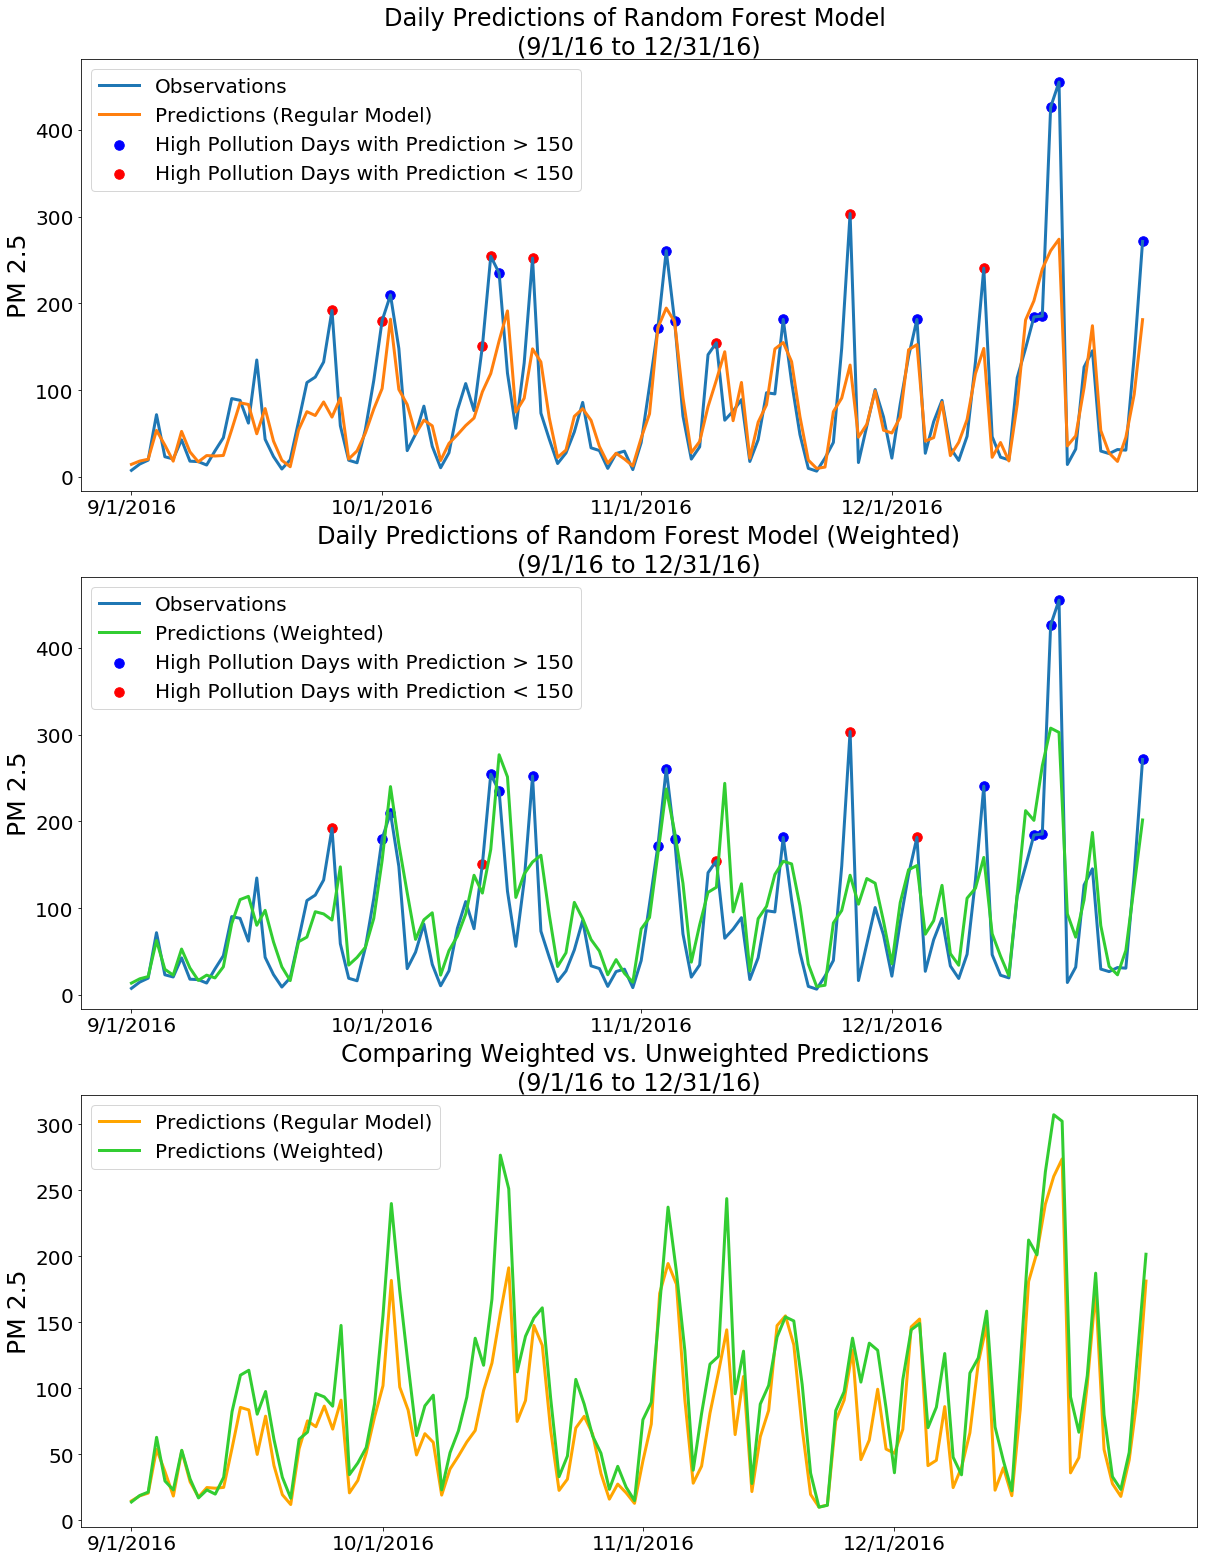

In [109]:
labels = ['9/1/2016', '10/1/2016', '11/1/2016', '12/1/2016']
pos = [842, 872, 903, 933]
high_pts = adjusted_Actuals[adjusted_Actuals>150]
preds_for_high_pts = adjusted_Preds[high_pts.index-842]
preds_for_high_pts2 = adjusted_Preds2[high_pts.index-842]

PHP = pd.Series(preds_for_high_pts, index=high_pts.index)
PHP2 = pd.Series(preds_for_high_pts2, index=high_pts.index)

bad_high_pts = high_pts[PHP<150]
good_high_pts = high_pts[PHP>=150]
bad_high_pts2 = high_pts[PHP2<150]
good_high_pts2 = high_pts[PHP2>=150]


plt.figure(figsize=(20, 27))
plt.subplot(311)
plt.plot(adjusted_Actuals, label= 'Observations', linewidth = 3)
plt.plot(np.arange(842, 964), adjusted_Preds, label='Predictions (Regular Model)', linewidth=3)
plt.title('Daily Predictions of Random Forest Model \n(9/1/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('PM 2.5', size=25)
plt.scatter(good_high_pts.index, good_high_pts, color='blue', s=90,
           label='High Pollution Days with Prediction > 150')
plt.scatter(bad_high_pts.index, bad_high_pts, color='red', s=90,
           label='High Pollution Days with Prediction < 150')
plt.legend(prop={'size':20})


plt.subplot(312)
plt.plot(adjusted_Actuals, label= 'Observations', linewidth = 3)
plt.plot(np.arange(842, 964), adjusted_Preds2, label='Predictions (Weighted)', 
         linewidth=3, color = 'limegreen')
plt.title('Daily Predictions of Random Forest Model (Weighted)\n(9/1/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('PM 2.5', size=25)
plt.scatter(good_high_pts2.index, good_high_pts2, color='blue', s=90, 
            label='High Pollution Days with Prediction > 150')
plt.scatter(bad_high_pts2.index, bad_high_pts2, color='red', s=90,
           label = 'High Pollution Days with Prediction < 150')
plt.legend(prop={'size':20})



plt.subplot(313)
plt.plot(np.arange(842, 964), adjusted_Preds, label='Predictions (Regular Model)', 
         linewidth=3, color= 'orange')
plt.plot(np.arange(842, 964), adjusted_Preds2, label='Predictions (Weighted)', 
         linewidth=3, color = 'limegreen')

plt.title('Comparing Weighted vs. Unweighted Predictions \n(9/1/16 to 12/31/16)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('PM 2.5', size=25)
plt.legend(prop={'size':20})


print()

# Plots for Training Segment 

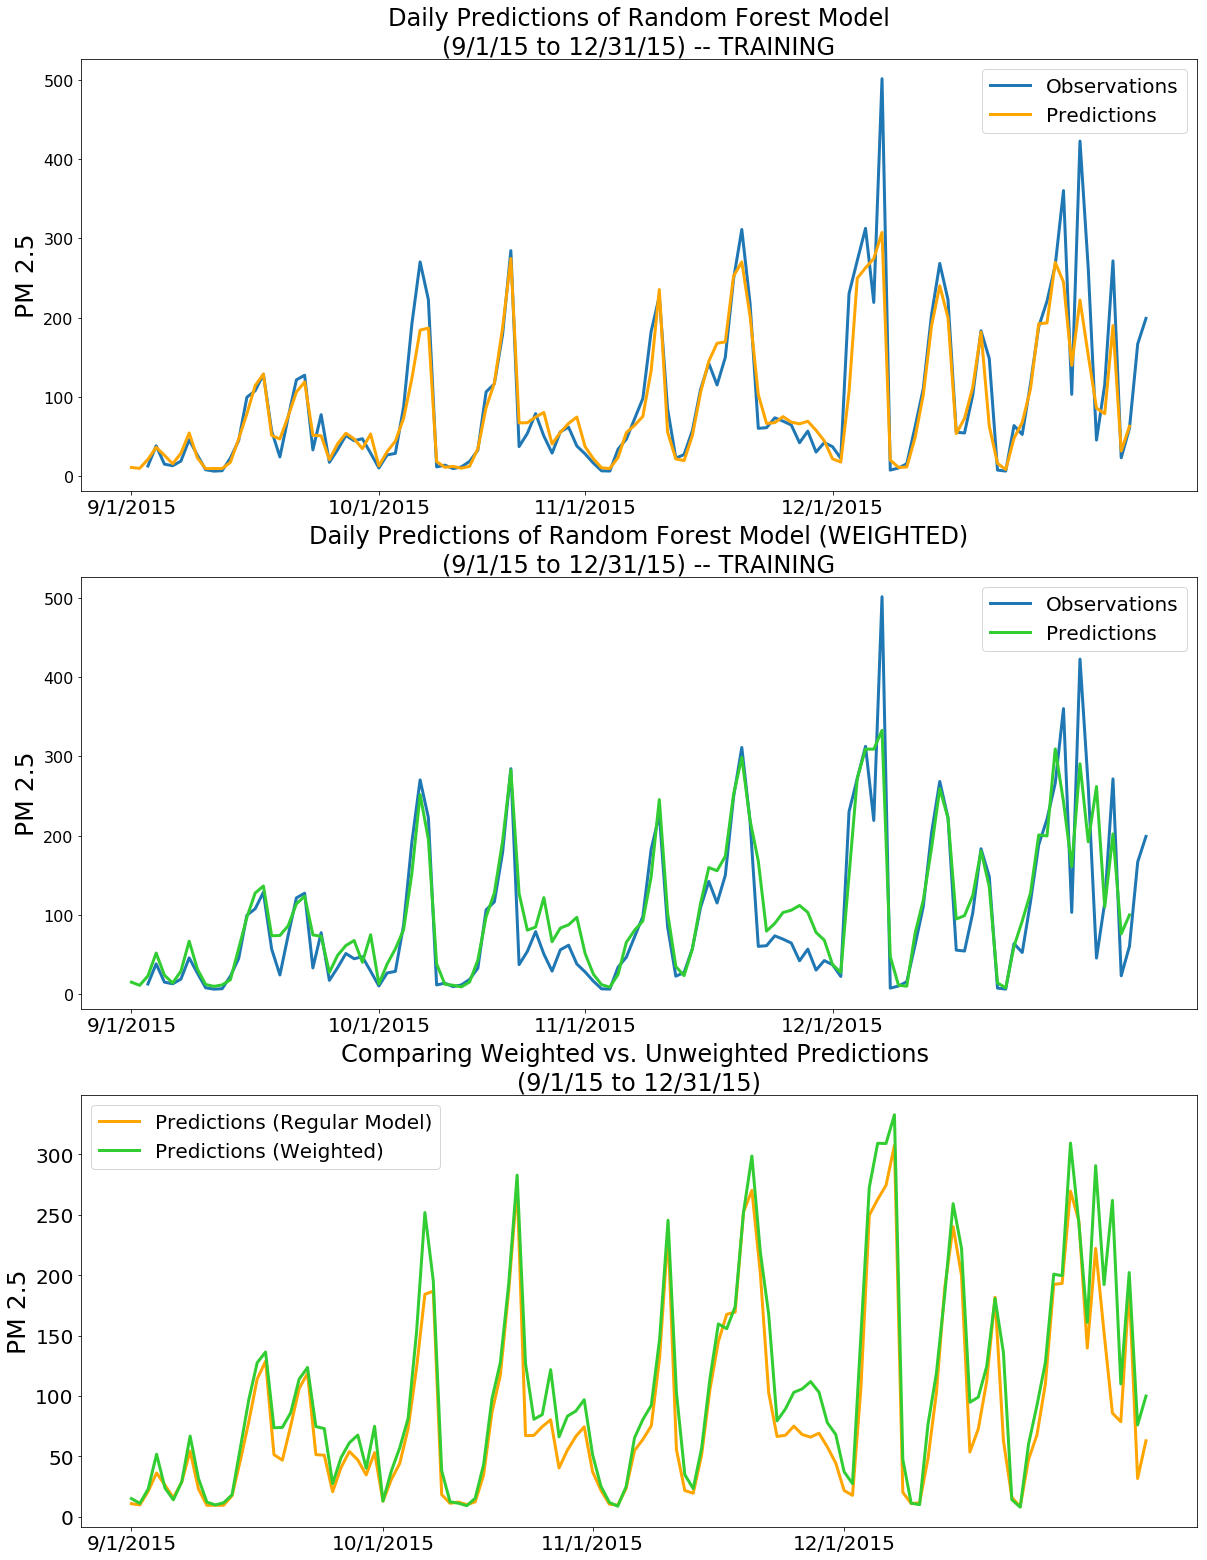

In [53]:
#Training Plot
labels = ['9/1/2015', '10/1/2015', '11/1/2015', '12/1/2015']
pos = [476, 506, 531, 561]


plt.figure(figsize=[20, 27])

plt.subplot(311)
plt.plot(adjusted_ActualsTrain[476:598], label= 'Observations', linewidth = 3)
plt.plot(np.arange(476, 598), adjusted_PredsTrain[474:596], 
         label='Predictions', linewidth=3, color='orange')
plt.title('Daily Predictions of Random Forest Model\n(9/1/15 to 12/31/15) -- TRAINING', size=24)
plt.yticks(size=16)
plt.xticks(pos, labels, size=20)
plt.ylabel('PM 2.5', size=25)
plt.legend(prop={'size':20})

plt.subplot(312)
plt.plot(adjusted_ActualsTrain2[476:598], label= 'Observations', linewidth = 3)
plt.plot(np.arange(476, 598), adjusted_PredsTrain2[474:596], 
         label='Predictions', linewidth=3, color='limegreen')
plt.title('Daily Predictions of Random Forest Model (WEIGHTED)\n(9/1/15 to 12/31/15) -- TRAINING', size=24)
plt.yticks(size=16)
plt.xticks(pos, labels, size=20)
plt.ylabel('PM 2.5', size=25)
plt.legend(prop={'size':20})


plt.subplot(313)
plt.plot(np.arange(476, 598), adjusted_PredsTrain[474:596], label='Predictions (Regular Model)', 
         linewidth=3, color= 'orange')
plt.plot(np.arange(476, 598), adjusted_PredsTrain2[474:596], label='Predictions (Weighted)', 
         linewidth=3, color = 'limegreen')

plt.title('Comparing Weighted vs. Unweighted Predictions \n(9/1/15 to 12/31/15)', size=24)
plt.xticks(pos, labels, size=20)
plt.yticks(size=20)
plt.ylabel('PM 2.5', size=25)
plt.legend(prop={'size':20})

print()

# Feature Importances 

In [54]:
RFF = pd.DataFrame(np.vstack((TrainX.columns.values, RF.feature_importances_))).T
RFF = RFF.sort_values(by=1, ascending=False)
RFF = RFF.rename(columns={0: 'Feature', 1: 'Gini Coefficient'}).reset_index(drop=True)
RFF

,Feature,Gini Coefficient
0,Wind Speed,0.231486
1,Beijing t-1,0.201913
2,wind_angle,0.201045
3,Baotou t-1,0.16234
4,Humidity,0.0786482
5,Harbin t-1,0.0315862
6,Xian t-1,0.0212367
7,Pressure,0.0161154
8,Temp.,0.0142671
9,Beijing t-2,0.014101


# Error Analysis - Test Set 

In [136]:
Results = pd.DataFrame(np.vstack((adjusted_Preds, adjusted_Preds2, adjusted_Actuals))).T
Results = Results.rename(columns={0: 'Predictions',1:'Preds_New', 2: 'Actual'})
Results.sort_values(by='Actual', ascending=False).head(20)

,Predictions,Preds_New,Actual
111,273.872135,302.482073,454.827491
110,260.645837,307.380110,425.991872
86,128.958385,137.992268,303.461429
121,181.250608,201.609496,271.293742
64,194.555569,237.327537,260.685671
43,119.140958,167.668753,254.245047
48,147.598408,153.251464,252.206598
102,148.086338,158.471022,240.625474
44,156.821288,276.736390,234.908845
31,181.769969,240.048175,209.639834


### Train/Test cutoff was 842, so we need to reference row 842+86 = 928 from the original dataset.  

In [131]:
subset = FINAL_Day_Log.loc[925:931]
subset = subset.drop(['month', 'weekday'], 1)

for c in subset.columns.values:
    if c!= 'date':
        subset[c] = round(subset[c], 2)

In [132]:
subset

,date,Beijing,Humidity,Pressure,Temp.,Wind Speed,wind_angle,Beijing t-1,Beijing t-2,Baotou t-1,Harbin t-1,Qingdao t-1,Xian t-1
925,2016-11-23,-0.81,34.54,30.58,29.15,9.68,48.75,-1.98,-1.59,-0.73,0.24,-0.91,-1.29
926,2016-11-24,-0.21,54.00,30.40,27.87,3.53,150.94,-0.81,-1.98,0.22,0.51,-0.33,-0.94
927,2016-11-25,1.11,63.88,30.27,30.05,3.44,146.25,-0.21,-0.81,0.36,0.42,0.47,0.04
928,2016-11-26,1.83,66.79,30.13,35.15,5.30,154.69,1.11,-0.21,0.74,1.04,0.15,0.42
929,2016-11-27,-1.08,48.04,30.35,34.25,7.26,100.31,1.83,1.11,0.67,0.90,0.08,0.15
930,2016-11-28,0.18,58.25,30.49,31.02,2.59,108.75,-1.08,1.83,0.53,1.12,1.12,0.71
931,2016-11-29,0.72,69.67,30.52,33.20,3.91,159.38,0.18,-1.08,0.88,0.49,-0.01,1.02


In [135]:
print(np.exp(1.11+3.89))
print(np.exp(1.83+3.89))

148.4131591025766
304.90492295690876


PM 2.5 on previous day (row 927) was 148.4 -- high, but not extremely high. 

------

# Wind Angle significant? 

In [41]:
wind_angle_table = PM_Hour.groupby('wind_angle').mean()[['Beijing']]
wind_angle_table['x'] = 1
wind_angle_table = wind_angle_table.sort_index(ascending=False)

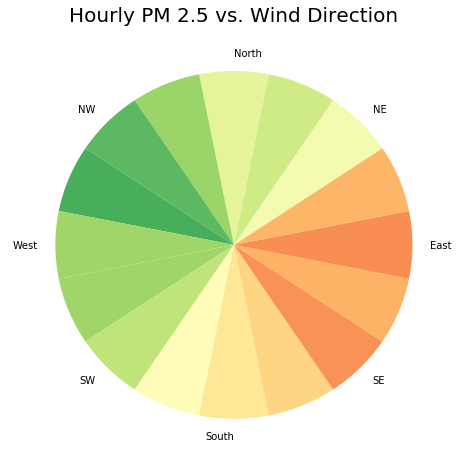

In [50]:
import matplotlib.colors
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=-150, vmax=-10)


labs = ['', 'SW', '', 'South', '', 'SE', '', 'East', '', 'NE', '',
        'North', '', 'NW', '', 'West']

plt.figure(figsize=[8,8])
plt.title('Hourly PM 2.5 vs. Wind Direction', size=20)
plt.pie(wind_angle_table['x'], labels = labs, startangle=191.25, 
        colors = cmap(norm(-1*wind_angle_table['Beijing'].values)))


print()